In [116]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset
import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [4]:
INPUT_PATH = "/root/workspace/var-wold/data/memetracker/dataset_memetracker_good.pk"

Load the dataset

In [5]:
dataset = Dataset.from_pickle(INPUT_PATH)

Visualize the dataset

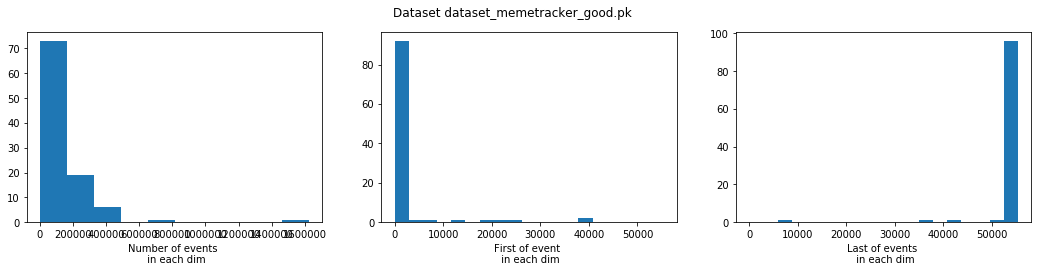

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = dataset.end_time
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

Print statistics of the dataset

In [7]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 15,168,774
               %NZ: 9.85%

Stats. of num. of events per dim:
count    1.000000e+02
mean     1.516877e+05
std      1.937082e+05
min      1.723000e+03
25%      7.706900e+04
50%      1.057855e+05
75%      1.740125e+05
max      1.624574e+06
dtype: float64


#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    100.000000
mean       0.088753
std        0.351734
min        0.000000
25%        0.000000
50%        0.000000
75%        0.002588
max        2.171700
dtype: float64

Busca estimators of **beta_{ji}**:
count    10000.000000
mean       168.738808
std       1087.665608
min          0.000000
25%          0.455349
50%          0.912856
75%          2.186691
max      17232.735281
dtype: float64



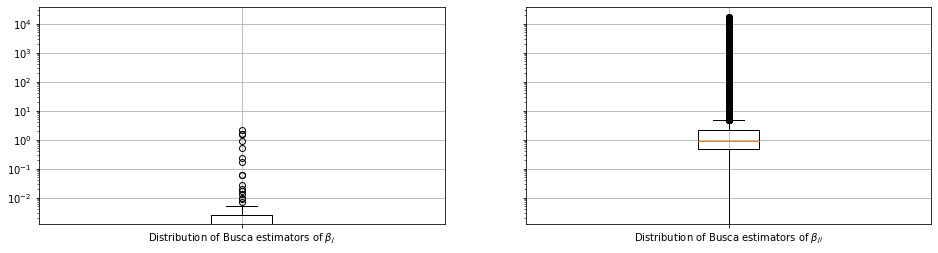

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) / np.exp(1) for ev in dataset.timestamps])
plt.sca(axs[0])
plt.grid()
plt.boxplot(busca_betas, labels=[r'Distribution of Busca estimators of $\beta_j$']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print()

plt.sca(axs[1])
plt.grid()
plt.boxplot(dataset.busca_beta_ji.flatten(), labels=[r'Distribution of Busca estimators of $\beta_{ji}$']);
plt.yscale('log')
print('Busca estimators of **beta_{ji}**:')
print(pd.Series(dataset.busca_beta_ji.flatten()).describe())
print()

#### Make variables for inference

In [9]:
def split_train_test(dataset, chunk_idx, chunk_total):
    # Set start and end times of train and test sets
    train_t0 = dataset.end_time * chunk_idx / chunk_total
    train_t1 = dataset.end_time * (chunk_idx + 1) / chunk_total
    test_t0 = dataset.end_time * (chunk_idx + 1) / chunk_total
    test_t1 = dataset.end_time * (chunk_idx + 2) / chunk_total
    # Filter the events in train/test observation windows
    train_events = [ev[(ev >= train_t0) & (ev < train_t1)] for ev in dataset.timestamps]
    test_events = [ev[(ev >= test_t0) & (ev < test_t1)] for ev in dataset.timestamps]
    # Remove dimensions with no nodes
    nodes_to_keep = np.array([(len(train_events[i]) > 0) & (len(test_events[i]) > 0)
                              for i in range(dataset.dim)])
    train_events = np.array(train_events)[nodes_to_keep].tolist()
    train_events = [ev - train_t0 for ev in train_events]
    test_events = np.array(test_events)[nodes_to_keep].tolist()
    test_events = [ev - test_t0 for ev in test_events]
    return train_events, test_events

Num. of dimensions: 94
    Num. of events: 985,924

Stats. of num. of events per dim:
count       94.000000
mean     10488.553191
std       9937.056298
min          2.000000
25%       3361.750000
50%       8094.000000
75%      14209.500000
max      45340.000000
dtype: float64


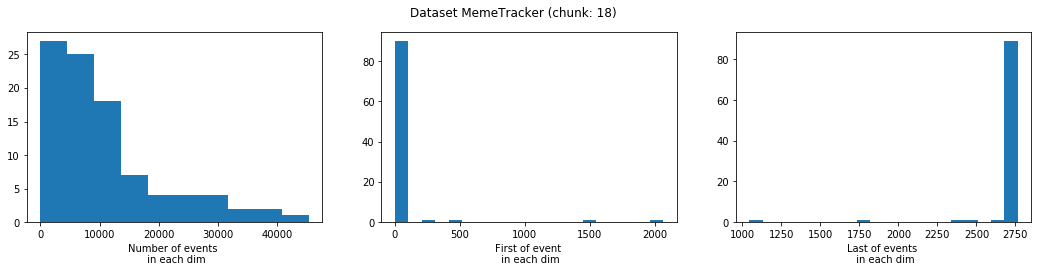

In [117]:
train_events, test_events = split_train_test(dataset, chunk_idx=18, chunk_total=20)

print(f"Num. of dimensions: {len(train_events):,d}")
print(f"    Num. of events: {sum(map(len, train_events)):,d}")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, train_events)))
print(pd.Series(num_jumps_per_dim).describe())

fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))
axs[0].hist(list(map(len, train_events)))
axs[0].set_xlabel('Number of events \n in each dim')
axs[1].hist(list(map(min, train_events)), bins=20)
axs[1].set_xlabel('First of event \n in each dim')
axs[2].hist(list(map(max, train_events)), bins=20)
axs[2].set_xlabel('Last of events \n in each dim')
fig.suptitle(f"Dataset MemeTracker (chunk: {chunk_idx})");

In [201]:
func = lambda events: min([np.min(np.diff(ev)) for ev in events if len(ev) > 1])

chunk_total = 20
for chunk_idx in range(chunk_total - 1):
    train_events, test_events = split_train_test(dataset, chunk_idx=chunk_idx, chunk_total=chunk_total)
    print(chunk_idx, func(train_events), func(test_events))

0 0.0 0.0
1 0.0 0.0
2 0.0 0.0
3 0.0 0.0
4 0.0 0.0
5 0.0 0.0
6 0.0 0.0
7 0.0 0.0
8 0.0 0.0
9 0.0 0.0
10 0.0 0.0
11 0.0 0.0
12 0.0 0.0
13 0.0 0.0
14 0.0 0.0
15 0.0 0.0
16 0.0 0.0
17 0.0 -0.0023453682733816095
18 -0.0023453682733816095 0.0


Init test model

In [118]:
test_model = tsvar.models.WoldModelOther()
test_model.observe(test_events)

---

## Run inference

---

### Run VI

In [123]:
dim = len(train_events)

# Set priors
# prior: Alpha
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 10.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 101.0 * np.ones((dim, dim))
br_pr = 100.0 * np.ones((dim, dim))

#bs_pr = 1000.0 * np.ones((dim, dim))
#med_inter_ev = np.array([np.median(np.diff(ev)) for ev in events])
#br_pr = np.ones((dim, dim)) * med_inter_ev * (bs_pr - 1)

# prior: Z
zc_pr = [1.0 * np.ones((len(train_events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('    mean:', as_pr[0,0] / ar_pr[0,0])
print('variance:', as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('    mean:', br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance:', br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
    mean: 0.1
variance: 0.01
BETA:
-----
    mean: 1.0
variance: 0.010101010101010102


In [124]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(train_events)

# Save model to pickle to avoid initializing cache many times on the same dataset.
#import pickle
#with open('/root/workspace/var-wold/data/memetracker/vi_model_dataset.pk', 'wb') as f:
#    pickle.dump((vi_model, dataset), f)

In [150]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=1,
    coeffs_true=np.ones(dim ** 2).flatten(),
    acc_thresh=0.05, dim=dim, widgets={'f1score', 'relerr'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=0, tol=1e-5, callback=callback)

False

In [151]:
vi_model._as_po, vi_model._ar_po = tsvar.models._wold_var._update_alpha(
    as_pr=vi_model._as_pr,
    ar_pr=vi_model._ar_pr,
    zp_po=vi_model._zp_po,
    bs_po=vi_model._bs_po,
    br_po=vi_model._br_po,
    dt_ik=vi_model.dt_ik,
    delta_ikj=vi_model.delta_ikj,
    valid_mask_ikj=vi_model.valid_mask_ikj,
)

vi_model._bs_po, vi_model._br_po, vi_model._b_x0, vi_model._b_xn =tsvar.models._wold_var._update_beta(
    x0=vi_model._b_x0,
    xn=vi_model._b_xn,
    n=1.7,
    as_po=vi_model._as_po,
    ar_po=vi_model._ar_po,
    zp_po=vi_model._zp_po,
    bs_pr=vi_model._bs_pr,
    br_pr=vi_model._bs_pr,
    dt_ik=vi_model.dt_ik,
    delta_ikj=vi_model.delta_ikj,
    valid_mask_ikj=vi_model.valid_mask_ikj,
)

In [154]:
zp_po = tsvar.models._wold_var._update_z(
    as_po=vi_model._as_po,
    ar_po=vi_model._ar_po,
    bs_po=vi_model._bs_po,
    br_po=vi_model._br_po,
    dt_ik=vi_model.dt_ik,
    delta_ikj=vi_model.delta_ikj,
    valid_mask_ikj=vi_model.valid_mask_ikj
)

In [161]:
epi = tsvar.models._wold_var._compute_epi(
    i=17, 
    as_po=vi_model._as_po, 
    ar_po=vi_model._ar_po, 
    bs_po=vi_model._bs_po, 
    br_po=vi_model._br_po, 
    dt_ik=vi_model.dt_ik, 
    delta_ikj=vi_model.delta_ikj, 
    valid_mask_ikj=vi_model.valid_mask_ikj
)

In [174]:
i = 17

# np.log(vi_model.valid_mask_ikj[i] * np.expand_dims(vi_model.dt_ik[i], 1) + 1e-20)

array([[-1.29, -4.61, -4.61, ..., -4.61, -4.61, -4.61],
       [-1.52, -1.52, -4.61, ..., -4.61, -4.61, -4.61],
       [-1.26, -1.26, -4.61, ..., -4.61, -4.61, -4.61],
       ...,
       [-1.27, -1.27, -1.27, ..., -1.27, -1.27, -1.27],
       [-4.61, -4.61, -4.61, ..., -4.61, -4.61, -4.61],
       [-4.61, -4.61, -4.61, ..., -4.61, -4.61, -4.61]])

In [186]:
(vi_model.valid_mask_ikj[i] * np.expand_dims(vi_model.dt_ik[i], 1))[4004, :].min()

-0.0023193359375

In [183]:
vi_model.valid_mask_ikj[i][4005, :]

array([ 1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,
        1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,
        1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,
        1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,
        1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  0.00,
        1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,
        1.00,  0.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,
        1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,
        1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,
        1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,  1.00,
        1.00,  1.00,  1.00,  1.00,  1.00])

In [176]:
np.expand_dims(vi_model.dt_ik[i], 1)

array([[ 0.26],
       [ 0.21],
       [ 0.27],
       ...,
       [ 0.27],
       [ 0.00],
       [ 0.00]], dtype=float32)

In [159]:
zp_po[17][4004,:]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [114]:
mu_hat = vi_model._as_po[0, :] / vi_model._ar_po[0, :]
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1

coeffs_hat = torch.tensor(np.hstack((
    mu_hat, beta_hat.flatten(), adj_hat.flatten()
)))


vi_ll = float(test_model.log_likelihood(coeffs_hat)) / sum(map(len, test_events))
vi_ll 

1.4502313824020276

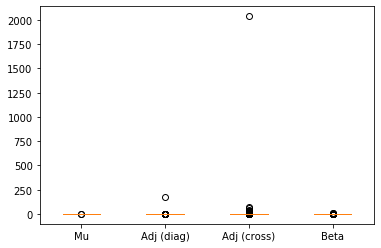

In [115]:
diag_mask = np.eye(dim).astype(bool)
plt.boxplot([mu_hat, adj_hat[diag_mask].flatten(), adj_hat[~diag_mask].flatten(), beta_hat.flatten()],
            labels=['Mu', 'Adj (diag)', 'Adj (cross)', 'Beta']);

---

### Run GB

In [ ]:
import gb
import time

dim = len(train_events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0 / len(train_events),
    num_iter=300,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=48,
)
granger_model.fit(train_events)

In [ ]:
mu_hat = granger_model.mu_
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * granger_model.beta_
coeffs_hat = torch.tensor(np.hstack((
    granger_model.mu_, beta_hat.flatten(), adj_hat.flatten()
)))

gb_ll = float(test_model.log_likelihood(coeffs_hat)) / sum(map(len, test_events))
gb_ll 

---

In [ ]:
print(vi_ll)
print(gb_ll)